In [1]:
# 如果缺少依赖，再取消注释安装
# !pip install seaborn


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load dataset

In [3]:
from pathlib import Path

# 支持环境变量或项目内相对路径，避免硬编码绝对路径
candidate_paths = [
    Path('/deeplearning/PJ1/Amazon_Unlocked_Mobile.csv'),
    Path('Amazon_Unlocked_Mobile.csv'),
    Path('data/Amazon_Unlocked_Mobile.csv')
]

for p in candidate_paths:
    if p.exists():
        data_path = p
        break
else:
    raise FileNotFoundError('未找到 Amazon_Unlocked_Mobile.csv，请将数据集放在项目根目录或 data/ 目录下')

df = pd.read_csv(data_path)
print(f'Loaded dataset from: {data_path.resolve()}')


# Preprocessing

In [4]:
df = df[['Reviews', 'Rating']].copy()

df.rename(columns={
    'Reviews': 'review_text',
    'Rating': 'rating'
}, inplace=True)

print(df.head())
print(df.shape)

                                         review_text  rating
0  I feel so LUCKY to have found this used (phone...       5
1  nice phone, nice up grade from my pantach revu...       4
2                                       Very pleased       5
3  It works good but it goes slow sometimes but i...       4
4  Great phone to replace my lost phone. The only...       4
(413840, 2)


In [5]:
# 检查缺失值
df.isnull().sum()

review_text    62
rating          0
dtype: int64

In [6]:
df.dropna(inplace=True)
print("After drop NA:", df.shape)

After drop NA: (413778, 2)


In [7]:
def label_sentiment(rating):
    if rating <= 2:
        return 0  # negative
    elif rating == 3:
        return 1  # neutral
    else:
        return 2  # positive

df['sentiment'] = df['rating'].apply(label_sentiment)

print(df['sentiment'].value_counts())


2    284954
0     97061
1     31763
Name: sentiment, dtype: int64


In [8]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)  # 去链接
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # 去符号
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['review_text'].apply(clean_text)

print(df[['review_text','clean_text']].head())

                                         review_text  \
0  I feel so LUCKY to have found this used (phone...   
1  nice phone, nice up grade from my pantach revu...   
2                                       Very pleased   
3  It works good but it goes slow sometimes but i...   
4  Great phone to replace my lost phone. The only...   

                                          clean_text  
0  i feel so lucky to have found this used phone ...  
1  nice phone nice up grade from my pantach revue...  
2                                       very pleased  
3  it works good but it goes slow sometimes but i...  
4  great phone to replace my lost phone the only ...  


In [9]:
# 添加文本长度特征
df['text_length'] = df['clean_text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

In [10]:
# Train-Test Split
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 331022
Test size: 82756


# EDA

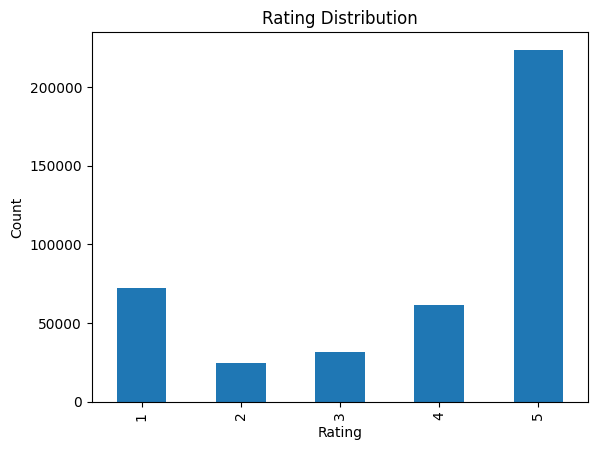

In [11]:
import matplotlib.pyplot as plt

df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

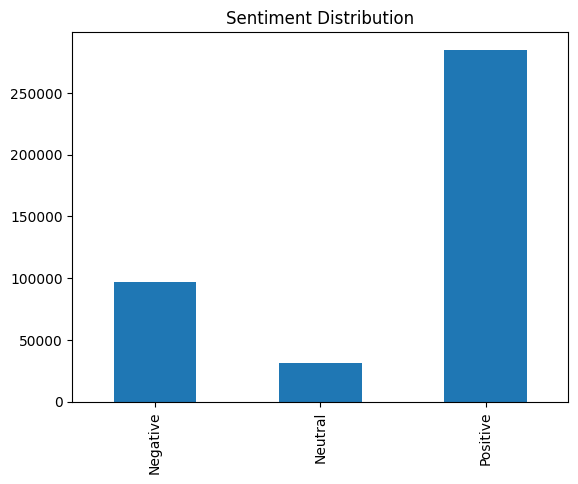

In [12]:
df['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.xticks([0,1,2], ['Negative','Neutral','Positive'])
plt.title("Sentiment Distribution")
plt.show()

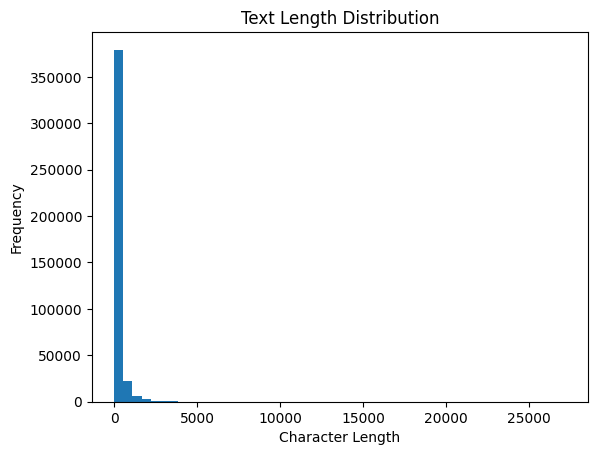

In [13]:
# 文本长度分布
plt.hist(df['text_length'], bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

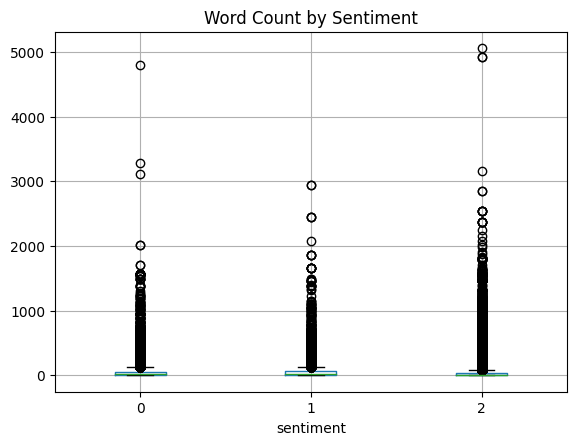

In [14]:
# 不同情感的文本长度对比
df.boxplot(column='word_count', by='sentiment')
plt.title("Word Count by Sentiment")
plt.suptitle("")
plt.show()

In [16]:
# 高频词分析
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X_counts = vectorizer.fit_transform(df['clean_text'])

print(vectorizer.get_feature_names_out())


['battery', 'bought', 'camera', 'dont', 'good', 'great', 'just', 'like', 'love', 'new', 'phone', 'phones', 'price', 'product', 'really', 'screen', 'time', 'use', 'work', 'works']


In [ ]:
# pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 520 kB 7.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# # words cloud
# from wordcloud import WordCloud

# text = " ".join(df['clean_text'].astype(str))
# wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text)

# plt.figure(figsize=(12,6))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title("Most Common Words in Mobile Reviews")
# # plt.show()

ImportError: The _imagingft C module is not installed

# Feature Extraction

In [19]:
tfidf = TfidfVectorizer(
    max_features=2000,
    stop_words='english',
    # ngram_range=(1,1)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)

Train shape: (331022, 2000)
Test shape: (82756, 2000)


In [21]:
feature_names = tfidf.get_feature_names_out()
print(feature_names[:20])


['ability', 'able', 'abroad', 'absolute', 'absolutely', 'accept', 'acceptable', 'access', 'accessories', 'accidentally', 'according', 'account', 'accounts', 'accurate', 'acting', 'activate', 'activated', 'activating', 'activation', 'active']


In [22]:
# 检查稀疏度（了解数据结构）
print("Non-zero elements:", X_train_tfidf.nnz)
print("Sparsity:", 100 * (1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])))

Non-zero elements: 4341361
Sparsity: 99.3442488716762


# Baseline Model

In [23]:
def evaluate_model(y_true, y_pred, model_name):
    
    acc = accuracy_score(y_true, y_pred)
    print(f"\n===== {model_name} =====")
    print("Accuracy:", acc)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=['Neg','Neu','Pos'],
                yticklabels=['Neg','Neu','Pos'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return acc

Logistic Regression


===== Logistic Regression =====
Accuracy: 0.8613635265116729

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81     19412
           1       0.51      0.11      0.18      6353
           2       0.90      0.96      0.92     56991

    accuracy                           0.86     82756
   macro avg       0.73      0.63      0.64     82756
weighted avg       0.84      0.86      0.84     82756



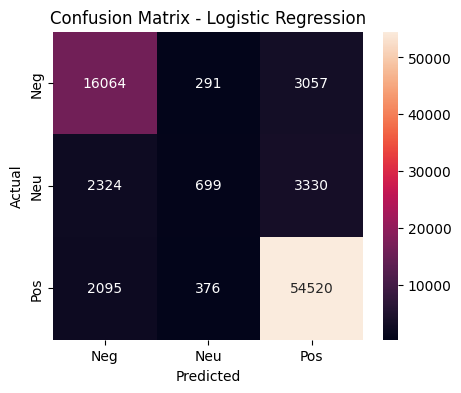

0.8613635265116729

In [24]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)

# print(classification_report(y_test, y_pred_lr))
evaluate_model(y_test, y_pred_lr, "Logistic Regression")


Naive Bayes



===== Naive Bayes =====
Accuracy: 0.8327492870607569

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     19412
           1       0.31      0.03      0.05      6353
           2       0.85      0.97      0.90     56991

    accuracy                           0.83     82756
   macro avg       0.65      0.57      0.57     82756
weighted avg       0.79      0.83      0.80     82756



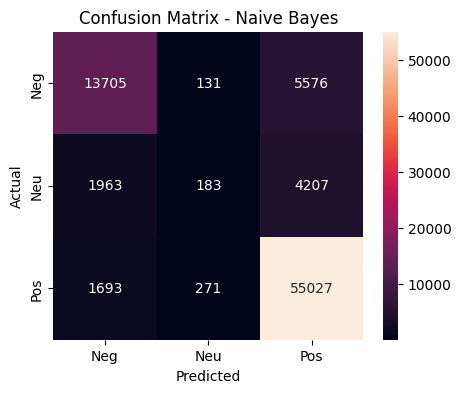

0.8327492870607569

In [25]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

nb_pred = nb_model.predict(X_test_tfidf)

# print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
# print(classification_report(y_test, nb_pred))

evaluate_model(y_test, nb_pred, "Naive Bayes")


===== Linear SVM =====
Accuracy: 0.8583063463676349

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80     19412
           1       0.59      0.04      0.08      6353
           2       0.89      0.96      0.92     56991

    accuracy                           0.86     82756
   macro avg       0.75      0.61      0.60     82756
weighted avg       0.84      0.86      0.83     82756



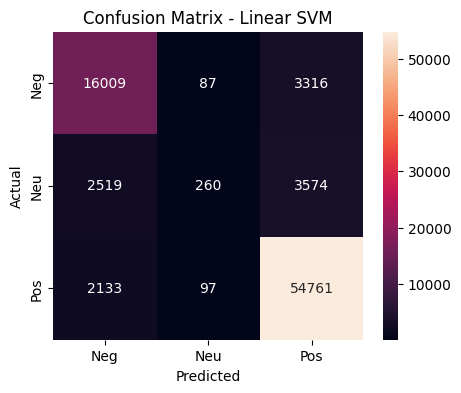

0.8583063463676349

In [26]:
svm = LinearSVC(random_state=42)
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)

evaluate_model(y_test, y_pred_svm, "Linear SVM")


In [ ]:
# # Confusion Matrix

# cm = confusion_matrix(y_test, y_pred_lr)

# sns.heatmap(cm, annot=True, fmt='d',
#             xticklabels=['Neg','Neu','Pos'],
#             yticklabels=['Neg','Neu','Pos'])
# plt.title("Confusion Matrix - Logistic Regression")
# plt.show()

Linear SVM

# Deep Learning Model(FNN Model)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [28]:
sample_size = min(50000, len(df))
df_small = df.sample(sample_size, random_state=42)

X_small = df_small['clean_text']
y_small = df_small['sentiment']


In [29]:
from sklearn.model_selection import train_test_split

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    random_state=42,
    stratify=y_small
)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=2000,
    stop_words='english'
)

X_train_tfidf_s = tfidf.fit_transform(X_train_s)
X_test_tfidf_s = tfidf.transform(X_test_s)

In [31]:
# 转成 tensor（使用小样本特征，降低内存占用）
X_train_tensor = torch.tensor(X_train_tfidf_s.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf_s.toarray(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_s.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_s.values, dtype=torch.long)


In [32]:
# 构建 dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [33]:
# 定义 FNN 模型
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [34]:
input_dim = X_train_tensor.shape[1]
model = FNN(input_dim, 128, 3)

In [35]:
# 定义 loss 和 optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
epochs = 20
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.4199
Epoch 2, Loss: 0.3670
Epoch 3, Loss: 0.3453
Epoch 4, Loss: 0.3261
Epoch 5, Loss: 0.3080
Epoch 6, Loss: 0.2912
Epoch 7, Loss: 0.2773
Epoch 8, Loss: 0.2643
Epoch 9, Loss: 0.2527
Epoch 10, Loss: 0.2428
Epoch 11, Loss: 0.2340
Epoch 12, Loss: 0.2264
Epoch 13, Loss: 0.2185
Epoch 14, Loss: 0.2126
Epoch 15, Loss: 0.2068
Epoch 16, Loss: 0.2014
Epoch 17, Loss: 0.1972
Epoch 18, Loss: 0.1921
Epoch 19, Loss: 0.1887
Epoch 20, Loss: 0.1851


In [37]:
from sklearn.metrics import classification_report

model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

accuracy = correct / total
print("FNN Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

FNN Accuracy: 0.9295036009473633

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     19412
           1       0.86      0.55      0.67      6353
           2       0.94      0.98      0.96     56991

    accuracy                           0.93     82756
   macro avg       0.90      0.81      0.84     82756
weighted avg       0.93      0.93      0.93     82756



In [ ]:
# model.eval()

# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         predicted = torch.argmax(outputs, dim=1)

#         all_preds.extend(predicted.tolist())
#         all_labels.extend(labels.tolist())

# # 计算准确率
# correct = sum([p == l for p, l in zip(all_preds, all_labels)])
# accuracy = correct / len(all_labels)

# print("FNN Accuracy:", accuracy)

In [ ]:
# print(classification_report(all_labels, all_preds))

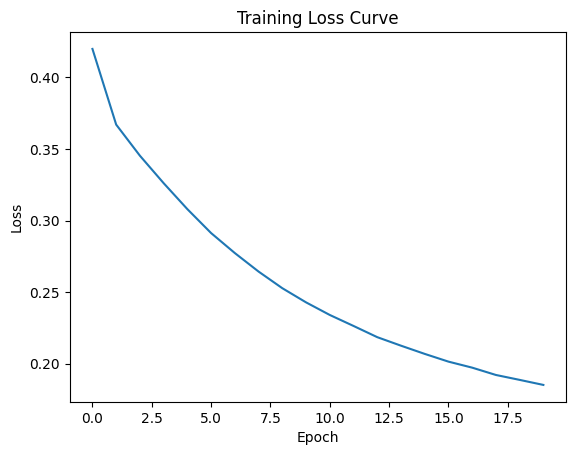

In [39]:
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

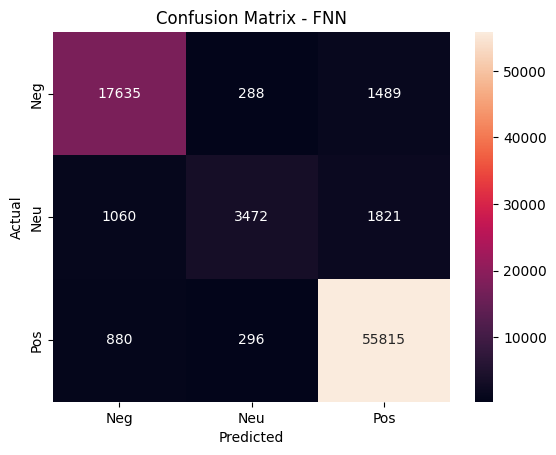

In [40]:
# FNN 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=['Neg','Neu','Pos'],
            yticklabels=['Neg','Neu','Pos'])

plt.title("Confusion Matrix - FNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

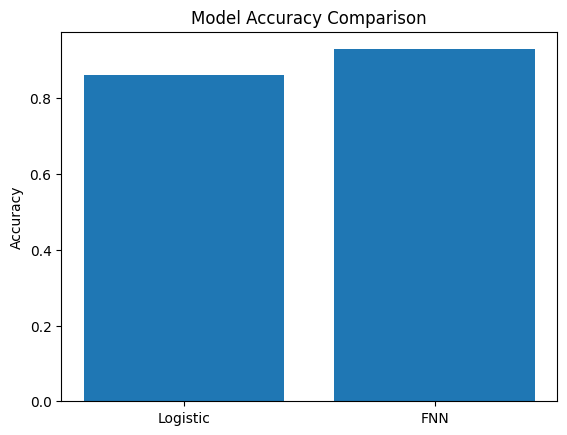

In [41]:
lr_acc = accuracy_score(y_test, y_pred_lr)
nb_acc = accuracy_score(y_test, nb_pred)
svm_acc = accuracy_score(y_test, y_pred_svm)
fnn_acc = accuracy

models = ['Logistic', 'Naive Bayes', 'Linear SVM', 'FNN']
accuracies = [lr_acc, nb_acc, svm_acc, fnn_acc]

plt.figure(figsize=(7,4))
plt.bar(models, accuracies, color=['#4C72B0','#55A868','#C44E52','#8172B3'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(min(accuracies)-0.02, max(accuracies)+0.02)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.001, f'{v:.3f}', ha='center', fontsize=9)
plt.show()
